In [1]:
import os, zipfile, gdown

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

from data_processing import *
from image_processing import *
print('tf version: ' + tf.__version__)

tf version: 2.10.0


In [ ]:
# download dataset
url = 'https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view?usp=sharing'
output = 'fcnn_.zip'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

In [ ]:
# extract the downloaded dataset to a local directory
local_zip = 'fcnn_.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./fcnn')
zip_ref.close()

The dataset you just downloaded contains folders for images and annotations. The *images* contain the video frames while the *annotations* contain the pixel-wise label maps. Each label map has the shape `(height, width , 1)` with each point in this space denoting the corresponding pixel's class. Classes are in the range `[0, 11]` (i.e. 12 classes) and the pixel labels correspond to these classes:

| Value  | Class Name    |
| -------| -------------| 
| 0      | sky |
| 1      | building      |
| 2      | column/pole      |
| 3      | road |
| 4      | side walk     |
| 5      | vegetation      |
| 6      | traffic light |
| 7      | fence      |
| 8      | vehicle     |
| 9      | pedestrian |
| 10      | byciclist      |
| 11      | void      |

For example, if a pixel is part of a road, then that point will be labeled `3` in the label map. Run the cell below to create a list containing the class names:
- Note: bicyclist is mispelled as 'byciclist' in the dataset.  We won't handle data cleaning in this example, but you can inspect and clean the data if you want to use this as a starting point for a personal project.

## Load and Prepare the Dataset
Next, you will load and prepare the train and validation sets for training. There are some preprocessing steps needed before the data is fed to the model. These include:

* resizing the height and width of the input images and label maps (224 x 224px by default)
* normalizing the input images' pixel values to fall in the range `[-1, 1]`
* reshaping the label maps from `(height, width, 1)` to `(height, width, 12)` with each slice along the third axis having `1` if it belongs to the class corresponding to that slice's index else `0`. For example, if a pixel is part of a road, then using the table above, that point at slice #3 will be labeled `1` and it will be `0` in all other slices. To illustrate using simple arrays:
```
# if we have a label map with 3 classes...
n_classes = 3
# and this is the original annotation...
orig_anno = [0 1 2]
# then the reshaped annotation will have 3 slices and its contents will look like this:
reshaped_anno = [1 0 0][0 1 0][0 0 1]
```

The following function will do the preprocessing steps mentioned above.

**`data_processing.py`** includes functions to create the tensorflow datasets from the images in these folders. Notice that before creating the batches in the `get_training_dataset()` and `get_validation_set()`, the images are first preprocessed using the `map_filename_to_image_and_mask()` function you defined earlier.

In [5]:
# BATCH_SIZE = 64

In [2]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('./fcnn/dataset1/images_prepped_train/','./fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('./fcnn/dataset1/images_prepped_test/','./fcnn/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)


Metal device set to: Apple M2


2022-10-14 14:04:54.727032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-14 14:04:54.727283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### `class_name` and `colors` are defined in `data_processing.py`

In [3]:
# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values 
for class_name, color in zip(class_names, colors):
    print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


### `image_processing.py` includes Visualization Utilities

2022-10-14 14:04:58.298252: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


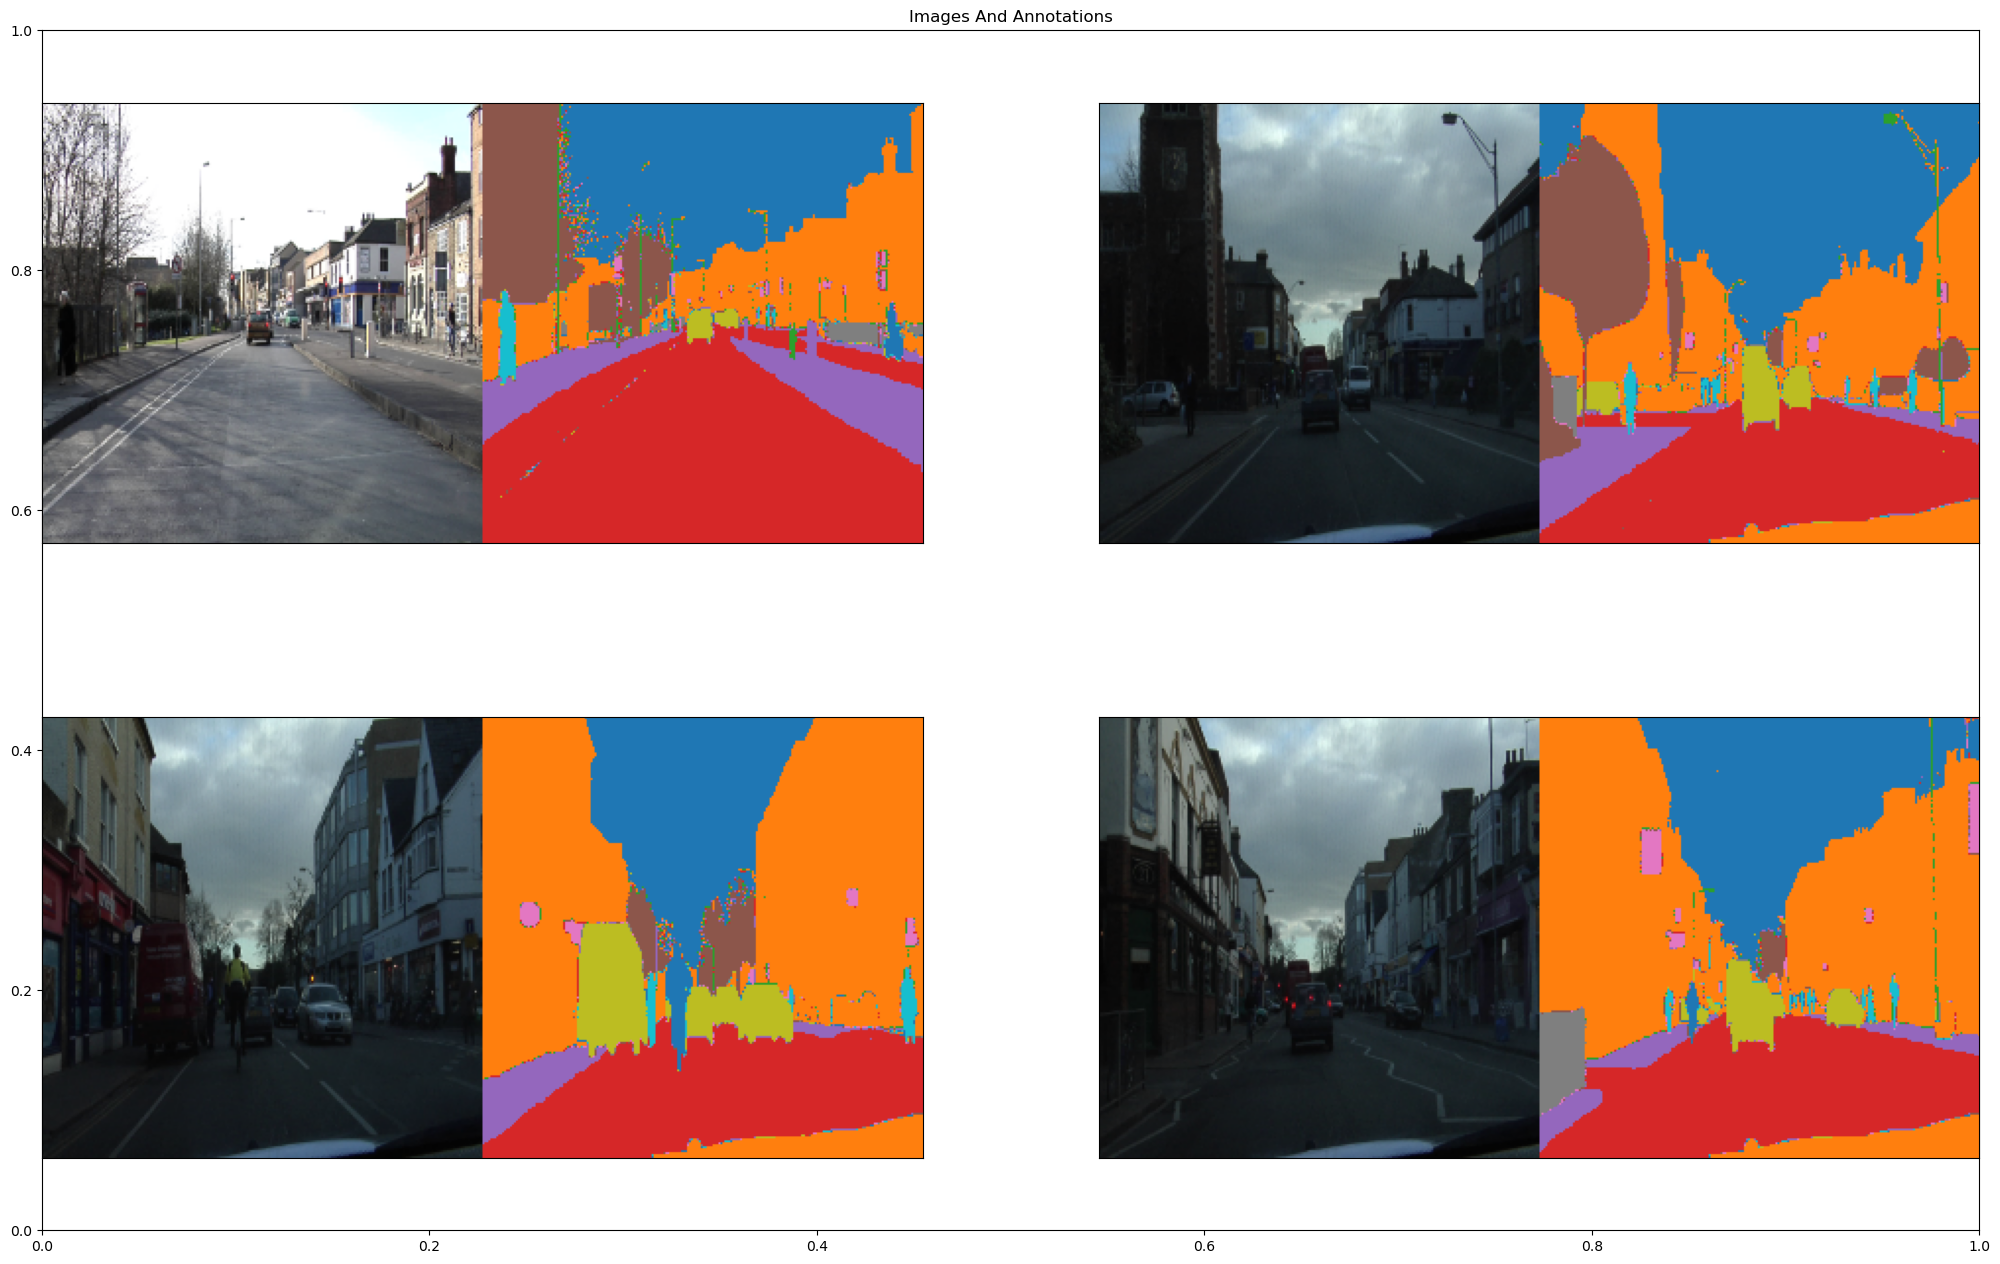

In [4]:
list_show_annotation(training_dataset, True)

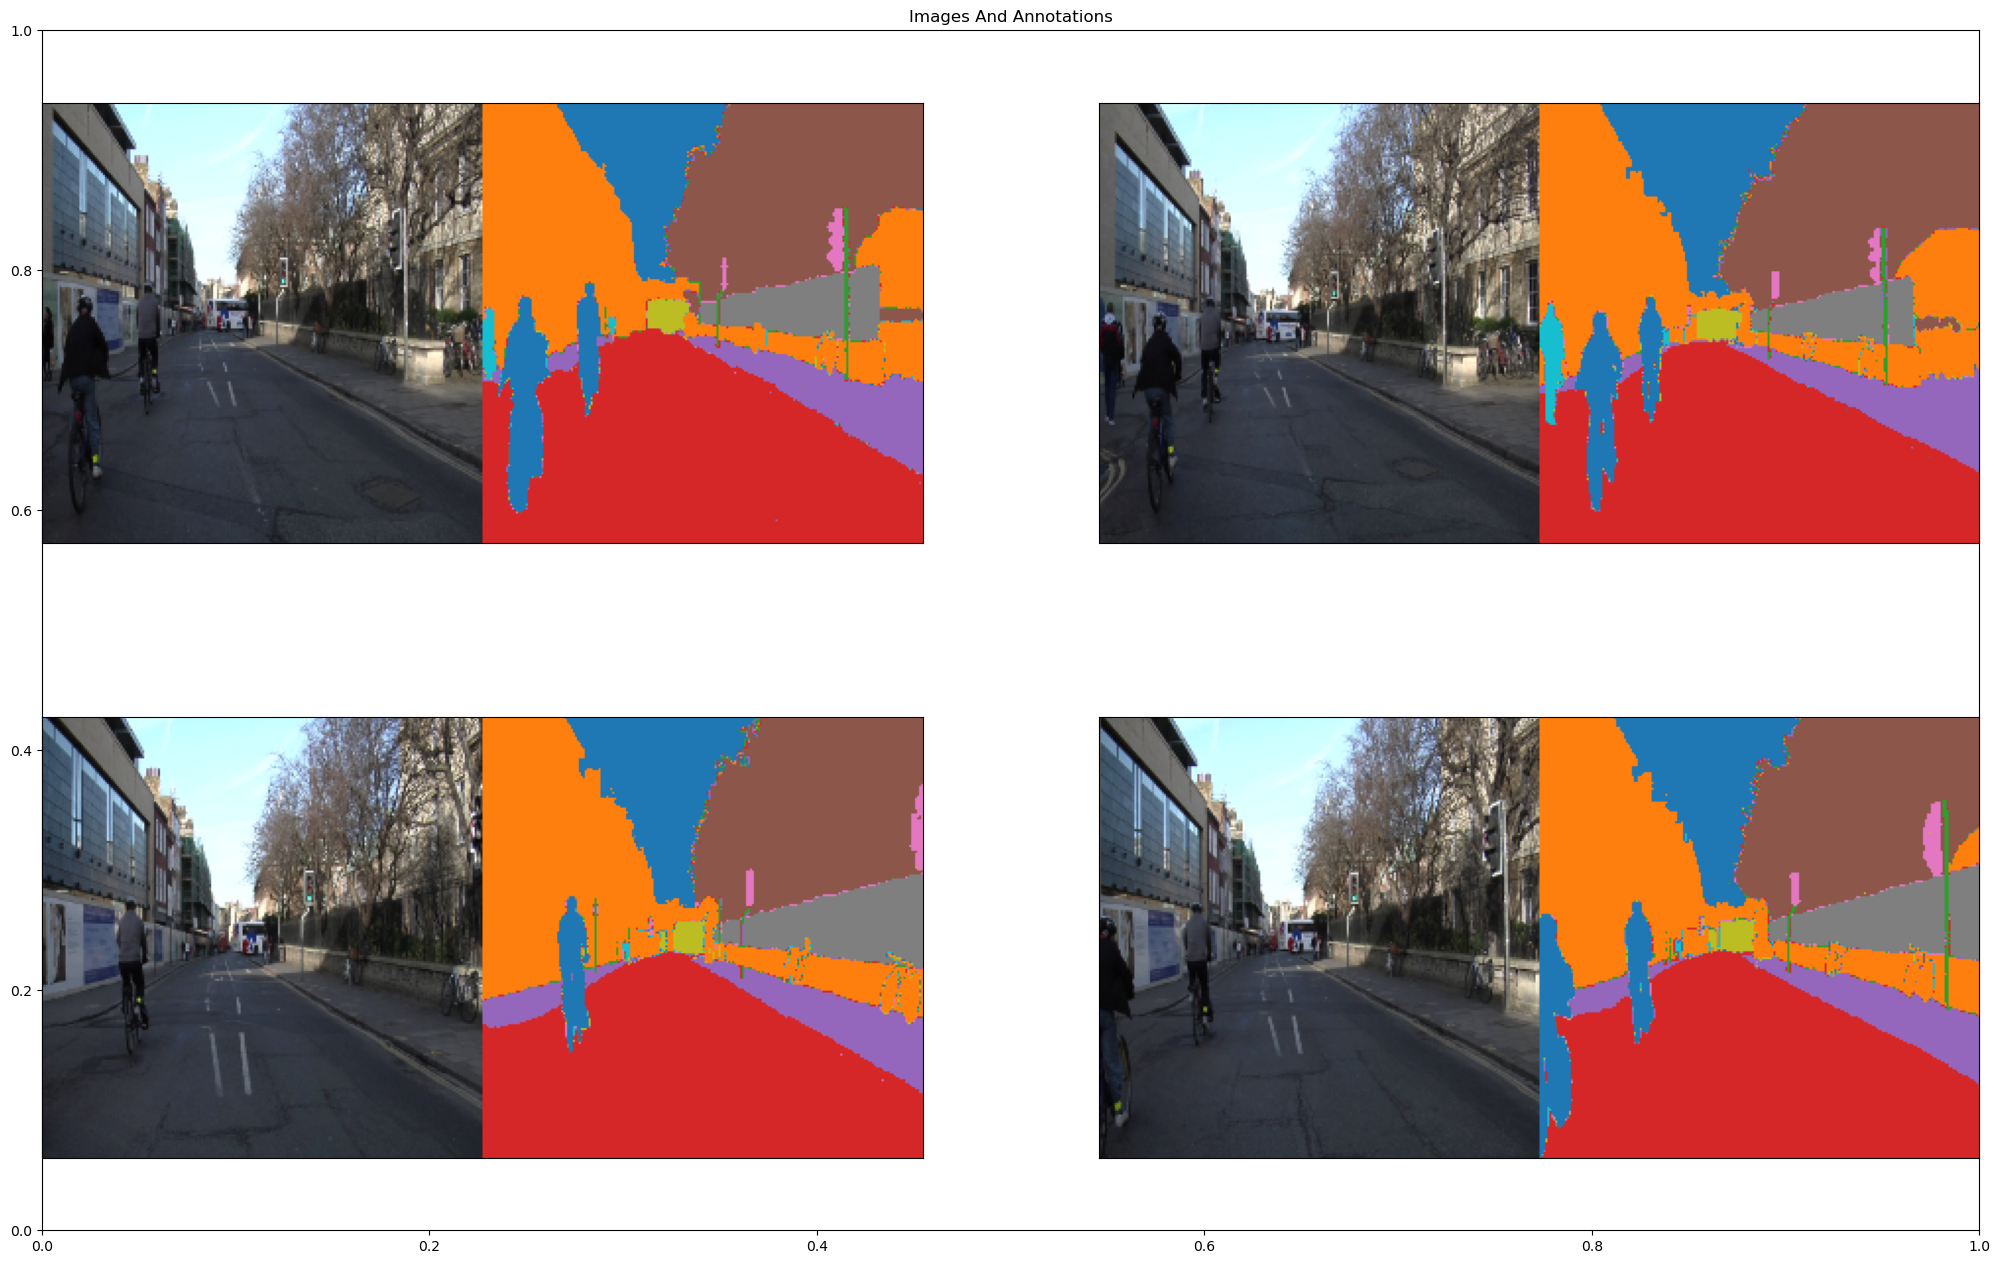

In [5]:
list_show_annotation(validation_dataset)

## Define the Model

Scratch a model and prepare it for training. It will use a VGG-16 network for the encoder and FCN-8 for the decoder. This is the diagram as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8' width="800" height="400">

## Define Pooling Block of VGG
VGG networks have repeating blocks so to make the code neat, it's best to create a function to encapsulate this process. Each block has convolutional layers followed by a max pooling layer which downsamples the image.

In [6]:
# Defines a block in the VGG network.
def block(x, n_convs, filters, kernel_size, activation, pooling_size, pooling_strides, block_name):
    '''
      Args:
        x (tensor) -- input image
        n_convs (int) -- number of convolution layers to append
        filters (int) -- number of filters for the convolution layers
        activation (string or object) -- activation to use in the convolution
        pool_size (int) -- size of the pooling layer
        pool_stride (int) -- stride of the pooling layer
        block_name (string) -- name of the block

      Returns:
        tensor containing the max-pooled output of the convolutions
    '''
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding='SAME',
                                   name="{}_conv{}".format(block_name, i+1))(x)
        
    x = tf.keras.layers.MaxPooling2D(pooling_size, pooling_strides, 
                                     name="{}_pool{}".format(block_name, i+1))(x)
    return x

### Download VGG weights

First, please run the cell below to get pre-trained weights for VGG-16. You will load this in the next section when you build the encoder network.

In [ ]:
# download the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [12]:
vgg_weights_path = "./model_weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

### Define VGG-16

build the encoder as shown below. 

* 5 blocks with increasing number of filters at each stage. 
* The number of convolutions, filters, kernel size, activation, pool size and pool stride will remain constant.
* load the pretrained weights after creating the VGG 16 network.
* Additional convolution layers will be appended to extract more features.
* The output will contain the output of the last layer and the previous four convolution blocks.

In [8]:
def VGG_16(image_input):
    '''
    Args:
        image_input (tensor) - batch of images
    Returns:
        tuple of tensors - output of all encoder blocks plus the final convolution layer
    '''
    
    x = block(image_input, n_convs=2, filters=64, kernel_size=(3,3), 
              activation='relu',pooling_size=(2,2), pooling_strides=(2,2), block_name='block1')
    p1 = x
    
    x =  block(x,n_convs=2, filters=128, kernel_size=(3,3), 
               activation='relu',pooling_size=(2,2), pooling_strides=(2,2), block_name='block2')
    p2 = x
    
    x = block(x,n_convs=3, filters=256, kernel_size=(3,3), 
              activation='relu',pooling_size=(2,2), pooling_strides=(2,2), block_name='block3')
    p3 = x
    
    x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
              activation='relu',pooling_size=(2,2), pooling_strides=(2,2), block_name='block4')
    p4 = x
    
    x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
              activation='relu',pooling_size=(2,2), pooling_strides=(2,2), block_name='block5')
    p5 = x
    
    vgg_model = tf.keras.Model(image_input, x)

    vgg_model.load_weights(vgg_weights_path)
    
    n = 4096 # number of filters for the output convolutional layers
    # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
    # we can extract more features by chaining two more convolution layers.
    
    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)
    

    return (p1, p2, p3, p4, c7)

### Define FCN 8 Decoder

Next, we will build the decoder using `deconvolution` layers. Please refer to the diagram for FCN-8 at the start of this section to visualize what the code below is doing. It will involve two summations before upsampling to the original image size and generating the predicted mask.

In [9]:
def fcn8_decoder(convs, n_classes):
    '''
      Defines the FCN 8 decoder.

      Args:
        convs (tuple of tensors) - output of the encoder network
        n_classes (int) - number of classes

      Returns:
        tensor with shape (height, width, n_classes) containing class probabilities
    '''

    # unpack the output of the encoder
    f1, f2, f3, f4, f5 = convs
  
    # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4), strides=(2,2), use_bias=False )(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

    # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2]) # skip connection

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4), strides=(2,2), use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1,1), activation='relu', padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])
  
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o)

    # append a softmax to get the class probabilities
    o = (tf.keras.layers.Activation('softmax'))(o)

    return o

### Define Final Model

You can now build the final model by connecting the encoder and decoder blocks.

In [10]:
def segmentation_model():
    '''
      Defines the final segmentation model by chaining together the encoder and decoder.

      Returns:
        keras Model that connects the encoder and decoder networks of the segmentation model
    '''
  
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(image_input=inputs)
    outputs = fcn8_decoder(convs, 12)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
    return model

In [13]:
# instantiate the model and see how it looks
model = segmentation_model()
# model.summary()

## Compile the model
Next, the model will be configured for training. You will need to specify the loss, optimizer and metrics. You will use `categorical_crossentropy` as the loss function since the label map is transformed to one hot encoded vectors for each pixel in the image (i.e. `1` in one slice and `0` for other slices as described earlier).

In [14]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [15]:
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 170
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

### one could either fit the model, the final accuracy should be around 0.85 after 170 epochs, or use the trained_weight `VGG_FCN8_weights.h5`

In [17]:
model.load_weights('./model_weights/VGG_FCN8_weights.h5')
# history = model.fit(training_dataset,
#                     steps_per_epoch=steps_per_epoch, 
#                     validation_data=validation_dataset, 
#                     validation_steps=validation_steps,
#                     epochs=EPOCHS)

## Evaluate the Model

After training, you will want to see how your model is doing on a test set. For segmentation models, you can use the intersection-over-union and the dice score as metrics to evaluate your model. You'll see how it is implemented in this section.

In [18]:
def get_images_and_segments_test_arrays():
    '''
      Gets a subsample of the val set as your test set

      Returns:
        Test set containing ground truth images and label maps
    '''
    y_true_segments = []
    y_true_images = []
    test_count = 64

    ds = validation_dataset.unbatch()
    ds = ds.batch(101)

    for image, annotation in ds.take(1):
        y_true_images = image
        y_true_segments = annotation


    y_true_segments = y_true_segments[:test_count, : ,: , :]
    y_true_segments = np.argmax(y_true_segments, axis=3)  

    return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

### Make Predictions

You can get output segmentation masks by using the `predict()` method. As you may recall, the output of our segmentation model has the shape `(height, width, 12)` where `12` is the number of classes. Each pixel value in those 12 slices indicates the probability of that pixel belonging to that particular class. If you want to create the predicted label map, then you can get the `argmax()` of that axis. This is shown in the following cell.

In [19]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

2022-10-14 14:06:11.482895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


### Compute Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. From the lectures, it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

The code below does that for you. A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [20]:
def compute_metrics(y_true, y_pred):
    '''
      Computes IOU and Dice Score.

      Args:
        y_true (tensor) - ground truth label map
        y_pred (tensor) - predicted label map
    '''
  
    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001

    for i in range(12):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
    
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)
    
        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

### Show Predictions and Metrics

You can now see the predicted segmentation masks side by side with the ground truth. The metrics are also overlayed so you can evaluate how your model is doing.

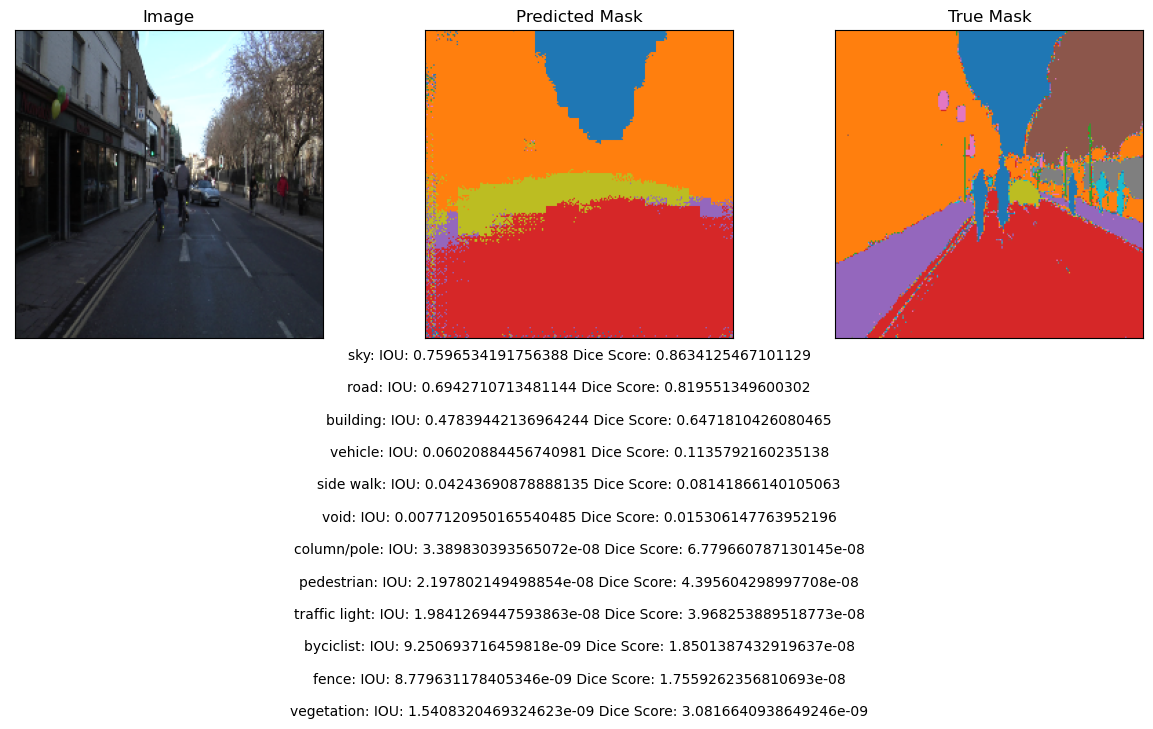

In [22]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 9

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider],
                y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], 
                 iou, dice_score, True)

# Display Class Wise Metrics

You can also compute the class-wise metrics so you can see how your model performs across all images in the test set.

In [23]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)

In [24]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 

sky            0.7755043683762904 
building       0.39271370854438076 
column/pole    4.533708117815792e-10 
road           0.7166229825477411 
side walk      0.03275066766712944 
vegetation     1.926255244192798e-11 
traffic light  5.544801772790462e-05 
fence          9.57808533982299e-11 
vehicle        0.06394819389611549 
pedestrian     4.53478142366462e-05 
byciclist      0.0005030729590875248 
void           0.0017067997505058586 


In [25]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

sky            0.8735595160462714 
building       0.5639546823398711 
column/pole    9.067416235631584e-10 
road           0.8349218085003681 
side walk      0.06342415201158277 
vegetation     3.852510488385596e-11 
traffic light  0.00011088988686213964 
fence          1.915617067964598e-10 
vehicle        0.12020922496936563 
pedestrian     9.069151585240489e-05 
byciclist      0.001005640008017172 
void           0.0034077830984554952 


In [ ]:
#save the model
# model.save('./VGG_FCN8.h5')